In [ ]:
# The script is loading the Andor-3 data from the .h5 files prodced from the LCLSII DAQ
# This script load some data from Ian's test runs
# 01/16/2025, Yusong, Sunnyvale
# 01/27/2025, update data loading according to the DAQ test
# 03/08/2025, update data loading according to the DAQ test on Mar. 5th
# 06/03/2025, update data loading according to the DAQ test on Mar. 5th

In [1]:
import os
# from natsort import natsorted
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# sys.path.append('/sdf/home/y/yusongl/UED/ana/python_packages/')
sys.path.append('/sdf/data/lcls/ds/ued_testfac/scratch/python_packages')
from ued_LCLSII_DAQ_utilities import *
from ued_solid_state_FY19_utilities import *
from gas_phase_UED_cython_functions import *
from scipy.optimize import curve_fit
from tqdm import tqdm
from h5py import File
from skimage import io
%matplotlib widget

<frozen importlib._bootstrap>:228: RuntimeWarning: compiletime version 3.7 of module 'gas_phase_UED_cython_functions' does not match runtime version 3.9
<frozen importlib._bootstrap>:228: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


In [2]:
def rebin_1d_mean(arr, fct):
    fct_rem = len(arr)%fct;
    if fct_rem > 0:
        arr = arr[:-fct_rem]
    new_size = (np.floor(len(arr)/fct)).astype(int)
    old_size = len(arr);
    factor   = old_size // new_size  # Must be an integer divisor
    return arr.reshape(new_size, factor).mean(axis=1)

In [4]:
# List the .h5 file names from the experiment smd directory
# exp         = 'uedc00104';
exp         = 'ued1006450';
exp         = 'ued1011086';

# you may not have the acess to this dataset
if 1 == 1:
    folderFiles = '/sdf/data/lcls/ds/ued/'+exp+'/hdf5/smalldata/' # The original directory
if 1 == 0: # the example data is also copied over to the public directory for UED
    folderFiles = '/sdf/data/lcls/ds/ued_testfac/scratch/AndorLCLSIIDAQ/AndorExampleData/'+exp+'/'

print('Folder under looking is: '+folderFiles);
files = os.listdir(folderFiles)
for file in files:
    if len(file)<25 and len(file)>10:
        print(file) # print the files

Folder under looking is: /sdf/data/lcls/ds/ued/ued1011086/hdf5/smalldata/
ued1011086_Run0027.h5
ued1011086_Run0021.h5
ued1011086_Run0018.h5
ued1011086_Run0004.h5
ued1011086_Run0022.h5
ued1011086_Run0010.h5
ued1011086_Run0025.h5
ued1011086_Run0016.h5
ued1011086_Run0005.h5
ued1011086_Run0017.h5
ued1011086_Run0011.h5
ued1011086_Run0028.h5
ued1011086_Run0003.h5
ued1011086_Run0026.h5
ued1011086_Run0008.h5
ued1011086_Run0019.h5
ued1011086_Run0024.h5
ued1011086_Run0014.h5
ued1011086_Run0009.h5
ued1011086_Run0015.h5
ued1011086_Run0020.h5
ued1011086_Run0012.h5
ued1011086_Run0007.h5
ued1011086_Run0001.h5
ued1011086_Run0013.h5
ued1011086_Run0002.h5
ued1011086_Run0023.h5


In [5]:
# Check the keys in the hdf5 file
RunNum = 21 # 
filename = r'/sdf/data/lcls/ds/ued/'+exp+'/hdf5/smalldata/'+exp+'_Run'+runNumToString(RunNum)+'.h5'
with h5py.File(filename,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'andor', 'epics_archiver', 'scan', 'timestamp', 'timing']>


In [6]:
# Further check the keys in the hdf5 file
with File(filename,'r') as f:
    print('The parent keys')
    print(f.keys())

    print('\nThe children keys')
    print('sum')
    print(f['Sums/'].keys())
    
    print('\nUserDataCfg')
    print(f['UserDataCfg/'].keys())

    print('\nUserDataCfg/andor')
    print(f['UserDataCfg/andor'].keys())
    print(f['UserDataCfg/andor/isGainswitching'])


    # print('\nUserDataCfg/epics')
    # print(f['UserDataCfg/epics'].keys())

    print('\nUserDataCfg/timing')
    print(f['UserDataCfg/timing'].keys())

    print('\nandor')    
    print(f['andor/'].keys())
        
    print('\nepics')
    # print(f['epics/'].keys())
    if 1 == 1:
        print('\nscan')
        print(f['scan/'].keys())

    print('\nepics_archiver')
    print(f['epics_archiver/'].keys())
    
    print('\ntiming')
    print(f['timing/'].keys())
    # print('sub-key under timing')
    # for key in f['timing/'].keys():
    #     print(key)

The parent keys
<KeysViewHDF5 ['Sums', 'UserDataCfg', 'andor', 'epics_archiver', 'scan', 'timestamp', 'timing']>

The children keys
sum
<KeysViewHDF5 ['andor_calib']>

UserDataCfg
<KeysViewHDF5 ['andor', 'timing']>

UserDataCfg/andor
<KeysViewHDF5 ['applyMask', 'common_mode', 'dataAccessTime', 'full__full_bound', 'full__full_calcPars', 'full__full_writeArea', 'isGainswitching']>
<HDF5 dataset "isGainswitching": shape (), type "|b1">

UserDataCfg/timing
<KeysViewHDF5 ['detname', 'name']>

andor
<KeysViewHDF5 ['full_area']>

epics

scan
<KeysViewHDF5 ['UED:USR:MMN:06:06', 'step_value']>

epics_archiver
<KeysViewHDF5 []>

timing
<KeysViewHDF5 ['destination', 'eventcodes', 'inhibitCounts', 'pulseId', 'timestamp']>


In [7]:
# Load the data from the .h5 file from on run and check
data = File(filename);
timestamp  = np.array(data['timestamp'])
order_step = timestamp.argsort()
ad_ufa     = np.array(data['andor/full_area'])[order_step] # Andor images, main data
# posi_stage1  = np.array(data['epics/MOTR_AS01_MC06_CH6'])[order_step] # Norminal Delay stage
# andor_cali = np.array(data['Sums/andor_calib'])[order_step] # Norminal Delay stage
# andor_confi = np.array(data['UserDataCfg/andor/full__full_calcPars'])# Norminal Delay stage
posi_stage   = np.array(data['scan/UED:USR:MMN:06:06'])[order_step] # Norminal Delay stage
# step_value   = np.array(data['scan/step_value'])[order_step] # Norminal Delay stage
# posi_stage   = np.array(data['scan/MOTR:AS01:MC03:CH1:MOTOR'])[order_step] # drive UV throttle
# posi_stage = np.array(data['epics']['MOTR_AS01_MC06_CH6'])[order_step];

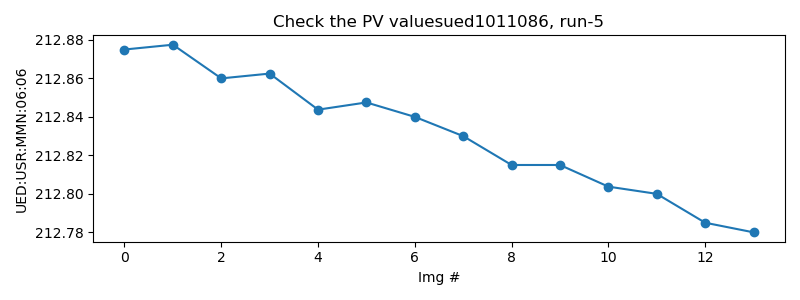

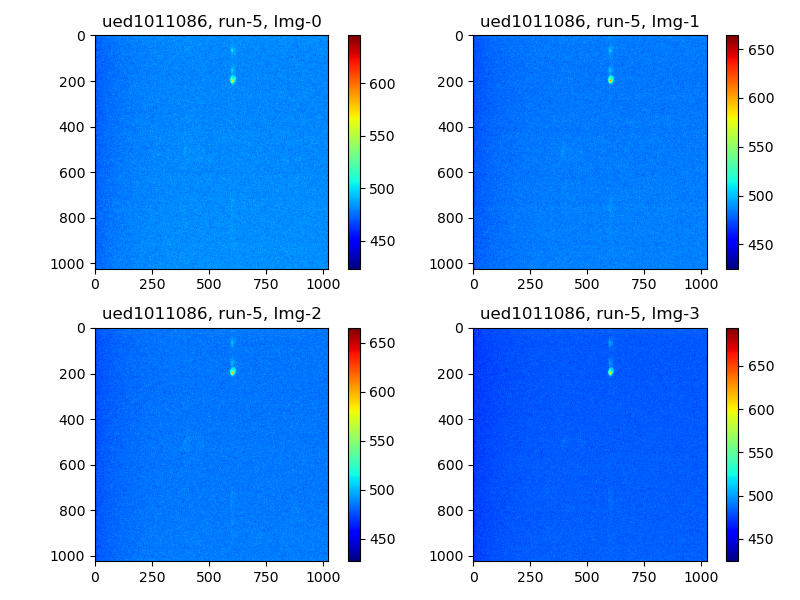

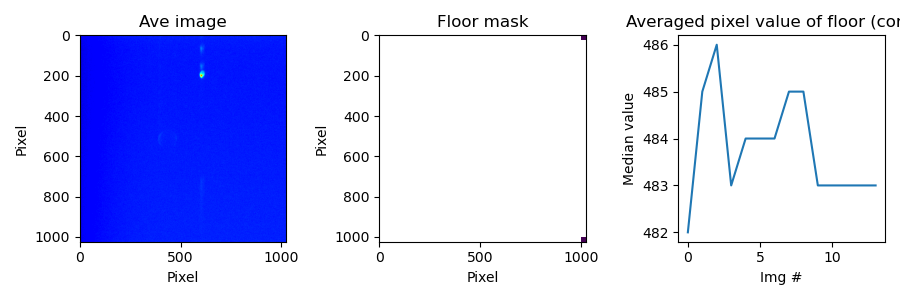

In [8]:
# Plot a few figures from the data
if 1 == 1: # plot the scan pv vales
    plt.figure(figsize=(8,3))
    # plt.subplot(1,2,1)
    plt.plot(posi_stage,'-o');
    plt.xlabel('Img #');plt.ylabel('UED:USR:MMN:06:06');plt.title('Check the PV values'+exp+', run-'+str(RunNum))
    
    # plt.subplot(1,2,2)
    # plt.plot(step_value,'-o');
    # plt.xlabel('Img #');plt.ylabel('PV values');plt.title('Check the PV values'+exp+', run'+str(RunNum))
    
    plt.tight_layout()
    plt.show()
    # print('PV values are: '+str(np.unique(posi_stage)))

plt.figure(figsize=(8,6))
for i_img in range(4):
    plt.subplot(2,2,i_img+1)
    plt.imshow(ad_ufa[i_img],cmap='jet');
    plt.colorbar()
    # plt.title(exp+', run-'+str(RunNum)+', Img-'+str(i_img)+', PV-'+str(round(posi_stage[i_img],4)))
    plt.title(exp+', run-'+str(RunNum)+', Img-'+str(i_img))
    plt.tight_layout()
    
plt.show()

# Subtracting the floor of each image by taking the median values of the EMCCD corners
sz_squ = 30 # The width of the square at the EMCCD corners
ufa_imgs_fl_free,ufa_imgs_bkg_sum, bkg_mask= img_flr_rem_LCLSDAQ(ad_ufa,sz_squ)

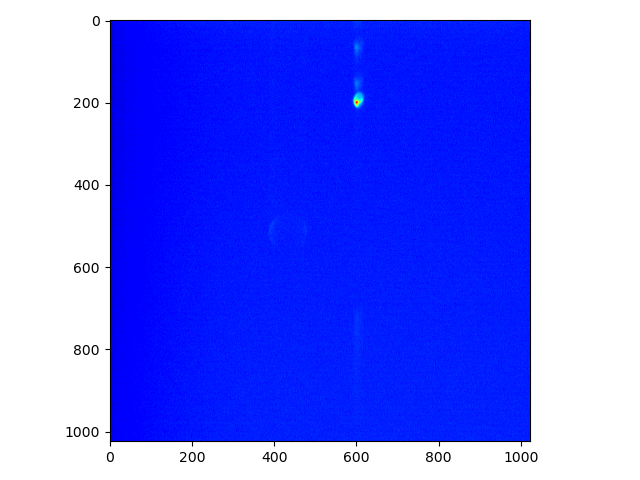

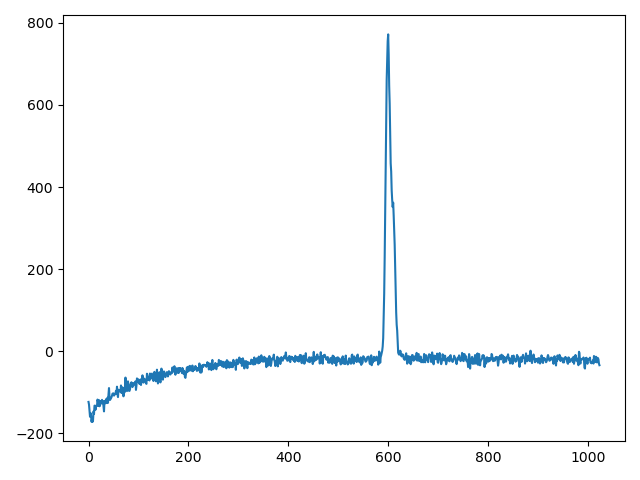

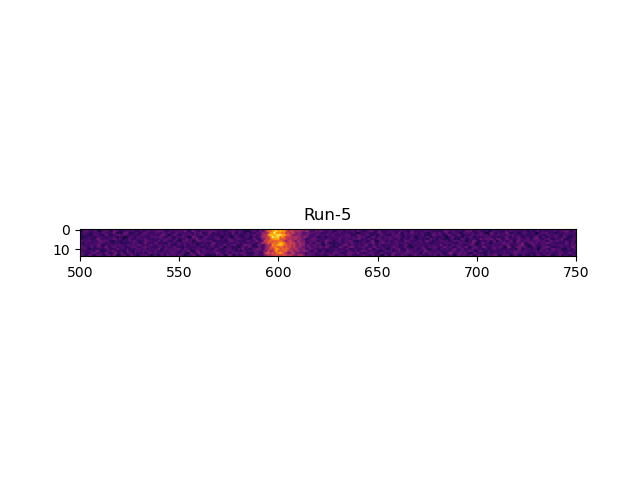

In [111]:
# Make a simple plot to check the integrated signal
plt.figure()
# plt.subplot(1,2,1)
plt.imshow(ufa_imgs_fl_free.mean(axis=0),cmap='jet')

# plt.subplot(1,2,2)
# img_step = ufa_imgs_fl_free[5]
# inte_step = ufa_imgs_fl_free[:,170:215,:].mean(axis=1)
# plt.imshow(inte_step)
# plt.plot(img_step[170:215,:].mean(axis=0))

plt.tight_layout()
plt.show()

plt.figure()
img_step = ufa_imgs_fl_free[5]
inte_step = ufa_imgs_fl_free[:,200:201,:].mean(axis=1)
plt.imshow(inte_step,cmap='inferno')
plt.title('Run-'+str(RunNum))
plt.xlim([500,750])

data=ufa_imgs_fl_free[:, 175:215, :].sum(axis=0).mean(axis=0)
plt.figure()
plt.plot(data)

plt.tight_layout()
plt.show()

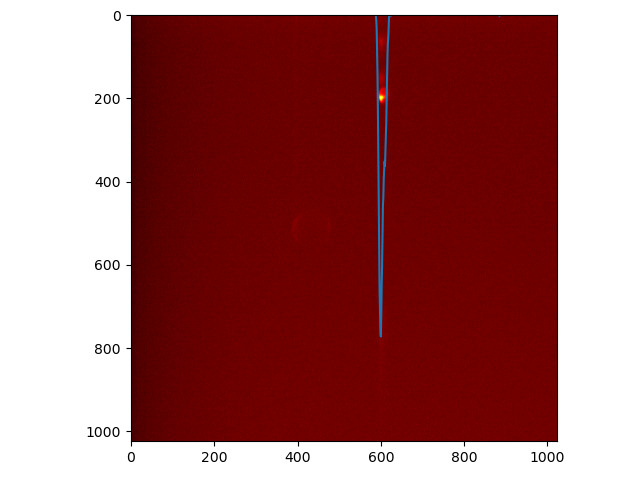

In [112]:

# Simulated image stack with shape (x, y, time)
image_stack = ufa_imgs_fl_free
num_frames = image_stack.shape[2]
plt.imshow(image_stack.mean(axis=0), cmap='hot', aspect='equal')
plt.show()

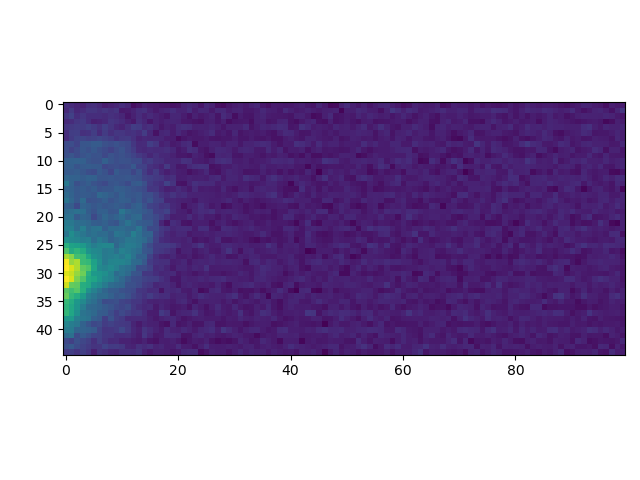

In [113]:
(image_stack.shape)
plt.imshow(image_stack[:,170:215,600:700].mean(0))
plt.show()

In [114]:

# Initialize centroid arrays
Centroidssx = []
Centroidssy = []

Co = 3e8  # Speed of light in m/s
Pixsize = 10  # micron
Time_axis_total = posi_stage  # Simulated time axis
num_frames=114
# Process each time frame
for frameindex in range(num_frames):
    A = image_stack[frameindex,170:215,600:700 ].T
    A=A-image_stack[0,170:215,600:700 ].T
    A2 = A.copy()

    # Centroid calculation
    Dataslice1 = np.sum(A2, axis=1)
    Dataslice2 = np.sum(A2, axis=0)
    xaxis = np.arange(0, len(Dataslice1) )
    yaxis = np.arange(0, len(Dataslice2) ).T

    centroid_x = np.sum(xaxis * Dataslice1) / np.sum(Dataslice1)
    centroid_y = np.sum(yaxis * Dataslice2) / np.sum(Dataslice2)

    Centroidssx.append(centroid_x)
    Centroidssy.append(centroid_y)


# Final centroid trace over time
plt.figure()
plt.subplot(2, 2, 1)
plt.plot((Time_axis_total[0:num_frames]- 213)* 1e-3 * 2 / Co * 1e12 ,np.array(Centroidssx))
plt.title("Centroid X Displacement")
plt.xlabel("Time (ps)")
plt.ylabel("ΔX (pixels)")
plt.tight_layout()
plt.show()


/lscratch/mothman/tmp/ipykernel_767007/3757684420.py:21: RuntimeWarning: invalid value encountered in scalar divide
  centroid_x = np.sum(xaxis * Dataslice1) / np.sum(Dataslice1)
/lscratch/mothman/tmp/ipykernel_767007/3757684420.py:22: RuntimeWarning: invalid value encountered in scalar divide
  centroid_y = np.sum(yaxis * Dataslice2) / np.sum(Dataslice2)


IndexError: index 14 is out of bounds for axis 0 with size 14

# Below cells, you need to develop by yourself to analyze your data

In [56]:
Time_axis_total.shape

(314,)

In [ ]:
# Compile the multiple runs to one dataset. Make sure loading the correct runs
RunNums = [20] # The useful Bi pump-probe scan 
runCount = 0;
for RunNum in RunNums: # Loop the runs
    print('Loading Andor signal from Run: '+str(RunNum))
    filename = r'/sdf/data/lcls/ds/ued/'+exp+'/hdf5/smalldata/'+exp+'_Run'+runNumToString(RunNum)+'.h5'
    data = File(filename);
    timestamp  = np.array(data['timestamp'])
    order_step = timestamp.argsort()
    ad_ufa     = np.array(data['andor/full_area'])[order_step] # Andor images, main data
    # posi_stage = np.arange(np.shape(timestamp)[0])
    posi_stage = np.array(data['scan/UED:DDG:01:aDelayAO'])[order_step]
    runCount   = runCount + 1;
    if runCount == 1:
        img_set = ad_ufa; # Andor data
        posi_set = posi_stage # PV values
    else:
        img_set = np.concatenate((img_set,ad_ufa),axis=0)
        posi_set = np.concatenate((posi_set,posi_stage),axis=0)
print('Finish loading data')
print('Total num. of imgs: '+str(np.shape(img_set)[0]));
img_set,img_set_flr_sum,mask_flr = img_flr_rem_LCLSDAQ(img_set,sz_squ); # Whether or not remove the floors 

In [ ]:
# Define a few RoIs and calibration, check the detector hole area
img_mean    = np.mean(img_set,axis=0) # The meqn the image
posi_unique = np.unique(posi_set) # Find the delay stage position
num_image_df= np.shape(img_set)[0] # number of imgs
print('Num. of Delay position is: '+str(len(posi_unique)))

# Generate the hole mask and plot the images
cm_y = 511 # center of the hole mask
cm_x = 436 # center of the hole mask
rm   = 45 # Radius
mask_hole = 1-gen_circular_mask(cm_x, cm_y, rm, 1024, 1024);mask_hole[mask_hole<1] = np.nan # hole mask

num_row = 1024;num_col = 1024 # Image dimensions
r_max   = 500 # maximum radius to perform azimuthal average (in pixel)
s_cal   = 0.0270 # s calibration (A-1 per pixel)
# s_cal   = 0.0125 # s calibration (A-1 per pixel)
s       = np.arange(r_max) * s_cal # total s range
pre_t0_point_num = 5 # number of time points before time zero, use for difference pattern calculation
# s1 = 2.7543;s2 = 4.747;s3 = 7.22 # RoIs: using the depletion peaks 
s1 = 1.98;s2 = 2.61;s3 = 3.79 # RoIs: using the depletion peaks 
r1 = int(s1 / s_cal);r2 = int(s2 / s_cal);r3 = int(s3 / s_cal) # Find the indices

plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plt.imshow(np.transpose(img_mean*mask_hole),cmap='jet');plt.colorbar(fraction=0.04)
plt.title('Andor, Bi, Linear');

img_mean[np.where(img_mean<0)] = 0.0001
plt.subplot(1,2,2)
plt.imshow(np.transpose(np.log(img_mean+0.0001)*mask_hole),cmap='jet');plt.colorbar(fraction=0.04)
plt.title('Andor, Bi, LogScale');
plt.clim([4, 9])

plt.tight_layout()
plt.show()

In [ ]:
from skimage.measure import find_contours, EllipseModel
from skimage.transform import AffineTransform, warp

In [ ]:
# Center finding: low and high threshold to find ring centroid
threshold_low  = 11000
threshold_high = 16000
center_diffraction = cal_one_diffraction_pattern_center_double_threshold(img_mean*mask_hole, threshold_low, threshold_high, flagPlot=102)
mask_diffraction   = gen_circular_mask(center_diffraction[0], center_diffraction[1], 80, num_row, num_col)
mask_diffraction   = (1 - mask_diffraction)*gen_circular_mask(center_diffraction[0], center_diffraction[1], 500, num_row, num_col)
# center_diffraction = [522, 523] # Uncomment this line if manual centroid input is needed
print('The found ctr at: '+str(center_diffraction))
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1) # Plot a figure of the center respect to the scattering image
plt.imshow(np.log(img_mean)*mask_hole,cmap = 'jet');plt.colorbar()
plt.plot(center_diffraction[0],center_diffraction[1],'o',color='r')
theta = np.linspace(0, 2 * np.pi, 200)
for i in range(4):
    x = np.cos(theta)*(i+2)*43+center_diffraction[0];y = np.sin(theta)*(i+2)*43+center_diffraction[1];
    plt.plot(x,y,linewidth=2,color='gray');
plt.clim([4,9]);plt.title('Diffraction Center')

angle,lineouts = radial_lineout(img_mean*mask_hole,np.flip(center_diffraction))# Calculate the radial lineout
plt.subplot(1,2,2)
plt.pcolormesh(s,angle,(lineouts*s**0),cmap='jet')
plt.axvline(x=s1,color='k');plt.axvline(x=s2,color='r');plt.axvline(x=s3,color='g');
plt.ylabel('Azimuthal angle [degree]');plt.xlabel(r'Q ($\AA^{-1}$)'),plt.title('Angular Lineouts, ')
plt.clim([0,15000])
plt.xlim([0,8])
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
mask_diffraction   = gen_circular_mask(center_diffraction[0], center_diffraction[1], 120, num_row, num_col)
mask_diffraction   = (1 - mask_diffraction)*gen_circular_mask(center_diffraction[0], center_diffraction[1], 240, num_row, num_col)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img_mean*mask_hole,cmap='jet');
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(mask_diffraction)

plt.subplot(1,3,3)
plt.imshow(img_mean*mask_diffraction,cmap='jet')
plt.show()

In [ ]:
# img_correct = img_mean*mask_hole
img_correct = img_mean*mask_diffraction
img_correct[np.isnan(img_correct)] = 0
# Assume `image` is your 2D numpy array
contours = find_contours(img_correct, level=np.max(img_correct) * 0.8)  # or another suitable level

# Fit to the largest contour
contour = max(contours, key=len)
model = EllipseModel()
model.estimate(contour)

cy, cx, a, b, theta = model.params  # center (cx, cy), major a, minor b, rotation angle

print(cy, cx, a, b, theta)

# 1. Rotate to align with axes
tform_rotate = AffineTransform(rotation=-theta)

# 2. Scale to correct ellipticity (minor/major axis ratio)
scale_y = a / b  # scale y to match x
tform_scale = AffineTransform(scale=(1, scale_y))

# 3. Rotate back
tform_rotate_back = AffineTransform(rotation=theta)

# Combine transforms: rotate → scale → rotate back
tform = (tform_rotate + tform_scale + tform_rotate_back)

# 4. Apply transform
corrected = warp(img_mean, tform.inverse)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_mean, cmap='jet');plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Corrected")
plt.imshow(corrected, cmap='jet');plt.colorbar()
plt.show()

In [ ]:
# Integrate the signal from each image
inten_mean_set = np.zeros((num_image_df, ))      # The averaged quantities for normalization
rad_pro_set    = np.zeros((r_max, num_image_df)) # The integrated trace along the Q axis
for ind in tqdm(range(num_image_df)):
    rad_pro_set[:,ind] = azimuthal_average_cython((center_diffraction), img_set[ind,:,:]*mask_hole, r_max)
    if 1 == 1: # where or not normalize on the intermedia range or not
        inten_mean_set[ind] = rad_pro_set[int(1.5/s_cal):int(8/s_cal), ind].mean(axis=0) # Calcul:ate the mean values of each imag
        rad_pro_set[:,ind] = rad_pro_set[:,ind] / inten_mean_set[ind] # Normalization

In [ ]:
# Calcuate the difference signal and plot the results
s1 = 1.98;s2 = 5.68;s3 = 4.12 # RoIs: using the depletion peaks 
r1 = int(s1 / s_cal);r2 = int(s2 / s_cal);r3 = int(s3 / s_cal) # Find the indices

std_filt =2; # Filter the images according to the total scattering intensity
rad_pro_avg  = np.zeros((r_max, len(posi_unique)))
rad_pro_std  = np.zeros((r_max, len(posi_unique)))
inten_mean_set_mean = inten_mean_set.mean();
inten_mean_set_std  = inten_mean_set.std();

# Filter the total counts and find out the good images
tc_good = np.squeeze(np.where(abs(inten_mean_set-inten_mean_set_mean)<std_filt*inten_mean_set_std)) # Find out the indices of the low counts images
rad_pro_use = rad_pro_set[:,tc_good]
for (ind_de, de) in enumerate(posi_unique):
    ind = np.where(posi_set[tc_good]==posi_unique[ind_de])
    rad_pro_avg[:,ind_de] = rad_pro_use[:,ind[0]].mean(axis=1)
    rad_pro_std[:,ind_de] = rad_pro_use[:,ind[0]].std(axis=1)
        
rad_pro_avg_pre_t0 = rad_pro_avg[:,-pre_t0_point_num:].mean(axis=1)

rad_pro_avg_diff = np.zeros_like(rad_pro_avg)
rad_pro_std_diff = np.zeros_like(rad_pro_avg)

for i in np.arange(rad_pro_avg.shape[1]):
    rad_pro_avg_diff[:,i] = (rad_pro_avg[:,i] - rad_pro_avg_pre_t0 ) / (rad_pro_avg_pre_t0+10**(-5)) * 100
    rad_pro_std_diff[:,i] = rad_pro_std[:,i] / (rad_pro_avg_pre_t0+10**(-5)) * 100
rad_pro_avg_diff[np.isnan(rad_pro_std_diff)] = 0
rad_pro_std_diff[np.isnan(rad_pro_std_diff)] = 0

plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
plt.plot(inten_mean_set, '-',linewidth=0.5,label=r'RMS intensity %2.1f %%'%(np.std(inten_mean_set)/np.mean(inten_mean_set)*100))
plt.plot(tc_good,inten_mean_set[tc_good], '--',label=r'RMS(selected with in %2.1f std) intensity %2.1f %%'%(std_filt,np.std(inten_mean_set[tc_good])/np.mean(inten_mean_set[tc_good])*100))
plt.axhline(y=inten_mean_set_mean+std_filt*inten_mean_set_std, color='orange', linestyle='-', label='Mean values+'+str(std_filt)+'xstd')
plt.axhline(y=inten_mean_set_mean-std_filt*inten_mean_set_std, color='orange', linestyle='-', label='Mean values-'+str(std_filt)+'xstd')
plt.axhline(y=inten_mean_set_mean, color='red', linestyle='-', label='Mean values of TC')
plt.legend(frameon=False)
plt.ylabel('Total intensity (arb. u.)');plt.xlabel('Image number');plt.title('images Intensity, run: '+str(RunNums));
# plt.xlim([0,1500]);plt.ylim([800,1700])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(s, rad_pro_avg[:,-pre_t0_point_num:], 'k-')
plt.axvline(x=s1,color='k');
plt.axvline(x=s2,color='r');
plt.axvline(x=s3,color='g');
plt.fill_between(s, rad_pro_avg[:,0]-rad_pro_std[:,0], rad_pro_avg[:,0]+rad_pro_std[:,0], alpha=0.8)
plt.title('Andor static signal');plt.xlabel(r'Q ($\AA^{-1}$)');plt.ylabel('Total scattering intensity');
plt.tight_layout()
plt.xlim([0,8.2])
# plt.show()

ax1 = plt.subplot(1,2,2)
ax1.plot(s, rad_pro_avg[:,-1], 'r-',label='Before t0')
ax1.plot(s, rad_pro_avg[:,1], 'b--', label='After t0')
ax1.axvline(x=s1,color='k');ax1.axvline(x=s2,color='r');ax1.axvline(x=s3,color='g');
ax1.set_xlabel('time (s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Intensity (arb. u.)', color='b')
ax1.tick_params('y', colors='b')
ax1.grid()

ax2 = ax1.twinx()
# ax2.plot(s[0:-40], rad_pro_avg_diff[0:-40,1], 'c-', label=r'$\Delta I/I_0$')
ax2.plot(s[:], np.mean(rad_pro_avg_diff[:,0:3],axis=1), 'c-', label=r'$\Delta I/I_0$')
ax2.plot(rebin_1d_mean(s, bin_fct), rebin_1d_mean(np.mean(rad_pro_avg_diff[:,0:3],axis=1), bin_fct),label='new bin')
ax2.set_ylabel(r'$\Delta I/I_0$ (%)', color='c')
ax2.tick_params('y', colors='c')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='best', frameon=False)
ax1.set_xlabel(r'Q ($\AA^{-1}$)')
ax1.set_title('Andor, Static, pumped and diff signal')
# ax1.set_xlim([0,8.2]);ax2.set_xlim([0,8.2])

plt.tight_layout()
plt.show()

In [ ]:
r_half_width = 8 # integration range
T0 = 0.00093; delay_time = (posi_unique-T0)/0.15 # convert from position to time in the delay range

plt.figure(figsize=(12,4))
vminP = -1;vmaxP = 1;
plt.subplot(1,3,2)
plt.pcolormesh(posi_unique, s, rad_pro_avg_diff, vmin=vminP, vmax=vmaxP, cmap='bwr');plt.colorbar() 
plt.axhline(y=s1,color='r');plt.axhline(y=s2,color='b');plt.axhline(y=s3,color='g');
plt.xlabel('Delay (mm)');plt.ylabel(r'Q ($\AA^{-1}$)');plt.title('Difference signal in [mm]');
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*(posi_unique.max()-posi_unique.min())/3+posi_unique.min(), s, 'k-', linewidth=2)
plt.ylim([0,8.2]);

delay_points = np.arange(len(posi_unique))
plt.subplot(1,3,1)
plt.pcolormesh(delay_points, s, rad_pro_avg_diff, vmin=vminP, vmax=vmaxP, cmap='bwr')
plt.colorbar() 
plt.xlabel('Delay scan point');plt.ylabel(r'Q ($\AA^{-1}$)');plt.title('Andor diff signal');
plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_points.max()/3, s, 'k-', linewidth=2)
plt.ylim([0,8.2]);

plt.subplot(1,3,3)
plt.pcolormesh(delay_time, s, rad_pro_avg_diff, vmin=vminP, vmax=vmaxP, cmap='bwr')
plt.colorbar()
plt.xlabel('Delay time (ps)');plt.ylabel(r'Q ($\AA^{-1}$)');plt.title('Difference signal in [ps]');
# plt.plot(rad_pro_avg[:,0]/rad_pro_avg[:,0].max()*delay_time.max()/3 + delay_time[0]*1, s, 'k-', linewidth=2)
# plt.axvline(x=0, color='red', linestyle='--', label='Vertical Line at x=2')
plt.ylim([0,8.2]);
plt.tight_layout()
plt.show()

inten_avg_1 = np.mean(rad_pro_avg_diff[r1-r_half_width:r1+r_half_width,:], axis=0)
inten_std_1 = np.sqrt(np.mean(rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r1-r_half_width:r1+r_half_width,:].shape[0]

inten_avg_2 = np.mean(rad_pro_avg_diff[r2-r_half_width:r2+r_half_width,:], axis=0)
inten_std_2 = np.sqrt(np.mean(rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r2-r_half_width:r2+r_half_width,:].shape[0]

inten_avg_3 = np.mean(rad_pro_avg_diff[r3-r_half_width:r3+r_half_width,:], axis=0)
inten_std_3 = np.sqrt(np.mean(rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:]**2, axis=0))/rad_pro_std_diff[r3-r_half_width:r3+r_half_width,:].shape[0]

plt.figure(figsize=(11*1, 6*1))

plt.subplot(2,3,1)
plt.errorbar(posi_unique, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s1)
plt.axvline(x=T0)
plt.text(T0,inten_avg_1.max(),str(T0))
plt.ylabel(r'$\Delta I/I_0$ (%)');plt.xlabel('Posi delay (mm)');
plt.title('Andor, run ')
plt.legend(frameon=False)

plt.subplot(2,3,2)
plt.errorbar(posi_unique, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s2)
plt.axvline(x=T0)
plt.text(T0,inten_avg_2.max(),str(T0))
plt.xlabel('Posi delay (mm)');plt.ylabel(r'$\Delta I/I_0$ (%)');plt.title('Preset T0: '+str(T0)+' mm')
plt.legend(frameon=False)

plt.subplot(2,3,3)
plt.errorbar(posi_unique, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s3)
plt.axvline(x=T0)
plt.text(T0,inten_avg_3.max(),str(T0))
plt.xlabel('Posi delay (mm)');plt.ylabel(r'$\Delta I/I_0$ (%)');plt.title(str(len(delay_points))+' dly steps')
plt.legend(frameon=False)

Time_real = -(posi_unique-T0)/0.15 # ps
plt.subplot(2,3,4)
plt.errorbar(Time_real, inten_avg_1, inten_std_1,color='r', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s1)
plt.axvline(x=0)
plt.ylabel(r'$\Delta I/I_0$ (%)');plt.xlabel('Time delay (ps)')
plt.title('Andor, run ')
plt.legend(frameon=False)
# plt.xlim([-2,4]);plt.ylim([-3,1])

plt.subplot(2,3,5)
plt.errorbar(Time_real, inten_avg_2, inten_std_2, color='b', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s2)
plt.axvline(x=0)
plt.xlabel('Time delay (ps)');plt.ylabel(r'$\Delta I/I_0$ (%)')
plt.legend(frameon=False)
plt.title('Andor, run ')
# plt.xlim([-2,4]);plt.ylim([-5,1])

plt.subplot(2,3,6)
plt.errorbar(Time_real, inten_avg_3, inten_std_3, color='g', fmt='-o', label=r'ave at q = %1.2f $\AA^{-1}$'%s3)
plt.axvline(x=0)
plt.xlabel('Time delay (ps)');plt.ylabel(r'$\Delta I/I_0$ (%)');plt.title('# of img: '+str(num_image_df))
plt.legend(frameon=False)
# plt.xlim([-2,4]);plt.ylim([-10,1])

plt.tight_layout()
plt.show()